<a href="https://colab.research.google.com/github/BAEK-SEUNGYUN/modu_deep/blob/main/nlp_BILSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BILSTM + CRF 개체명인식

In [1]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0


     |████████████████████████████████| 109.3MB 68kB/s 
     |████████████████████████████████| 491kB 40.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 317kB 12.7MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 49kB/s 


In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-h10krfh_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-h10krfh_
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=fd7553f75e1dc9c58d1fd8267b4aefd964bb9c8b03387f6516d91e2bb03c508f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxxgiqyo/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-0hefdvab
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-0hefdvab
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=b92419243205070fde04843af066db8766d691f0ba63e7e2159b6256c86aecef
  Stored in directory: /tmp/pip-ephem-wheel-cache-gim_opug/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [6]:
data = pd.read_csv('/content/drive/MyDrive/dataset/ner_dataset.csv', encoding='latin1')

In [7]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [9]:
print(f'데이터프레임 행의 갯수 : {len(data)}')

데이터프레임 행의 갯수 : 1048575


In [10]:
print('데이터 NULL값이 있는지 유무 : '+str(data.isnull().values.any()))

데이터 NULL값이 있는지 유무 : True


In [11]:
print('어떤 열에 NULL값이 있는지 출력')
print('==============================')
data.isnull().sum() #각 열마다 null값의 갯수를 보여줌

어떤 열에 NULL값이 있는지 출력


Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [15]:
print('sentence # 열의 중복을 제거한 값의 갯수 : {}'.format(data['Sentence #'].nunique()))
print('Word열의 중복을 제거한 값의 갯수 : {}'.format(data.Word.nunique()))
print('Tag열의 중복을 제거한 값의 갯수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 갯수 : 47959
Word열의 중복을 제거한 값의 갯수 : 35178
Tag열의 중복을 제거한 값의 갯수 : 17


In [16]:
print('Tag 열의 각각의 값의 갯수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 갯수 카운트
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


In [17]:
data = data.fillna(method="ffill") #Null값을 가진 행의 바로 앞의 값으로 NULL값을 채우는 작업을 수행

In [18]:
print(data.tail())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
1048574  Sentence: 47959     attack   NN   O


In [19]:
print('데이터에 Null값이 있는지 유무 : '+str(data.isnull().values.any()))

데이터에 Null값이 있는지 유무 : False


In [20]:
data['Word'] = data['Word'].str.lower()
print('Word열의 중복을 제거한 값의 갯수 : {}'.format(data.Word.nunique()))

Word열의 중복을 제거한 값의 갯수 : 31817


In [21]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [22]:
func = lambda temp: [(w, t) for w, t in zip(temp["Word"].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences = [t for t in data.groupby("Sentence #").apply(func)]
print("전체 샘플 갯수: {}".format(len(tagged_sentences)))

전체 샘플 갯수: 47959


In [23]:
print(tagged_sentences[0]) #첫번째 샘플 출력

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [24]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: 
  sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅정보들은 tag_info저장
  sentences.append(list(sentence)) #각 샘플에서 단어 정보만 저장
  ner_tags.append(list(tag_info)) #각 샘플에서 개체명 태깅 정보만 저장


In [25]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [26]:
print(sentences[90])
print(ner_tags[90])

['general', 'pinochet', 'has', 'been', 'indicted', 'for', 'tax', 'fraud', 'for', 'allegedly', 'hiding', '$', '27', 'million', 'in', 'foreign', 'bank', 'accounts', '.']
['B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 104
샘플의 평균 길이 : 21.863988


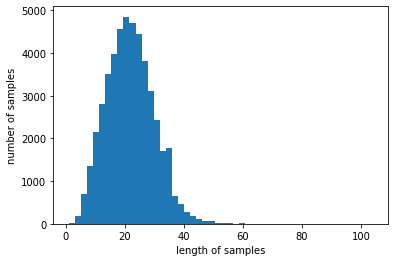

In [27]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만, 인덱스 1에는 단어 'OOV'를 할당
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자 유지한채 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [29]:
vocab_size = len(src_tokenizer.word_index)+1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기: {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기: 31819
개체명 태깅 정보 집합의 크기 : 18


In [30]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [31]:
x_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [32]:
print(x_data[0])
print(y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


In [33]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [34]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


In [35]:
decoded = []
for index in x_data[0]: # 첫번째 샘플 안의 인덱스들에 대해서
  decoded.append(index_to_word[index]) #다시 단어로 변환

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [36]:
max_len = 70
x_data = pad_sequences(x_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.2, random_state =777)

In [38]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [39]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


### F1-Score test

In [40]:
true = ['B-PER', 'I-PER', 'O', 'O','B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O','B-PER','I-PER', 'O', 'O', 'O', 'O', 'O', 'O','B-MISC','I-MISC','I-MISC', 'O', 'O', 'O', 'O', 'O', 'O','B-PER','I-PER', 'O', 'O', 'O', 'O', 'O']

In [41]:
# 실제값
pred = ['O'] * len(true)
print(pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [42]:
hit = 0 # 정답 갯수
for t, p in zip(true, pred):
  if t == p:
    hit += 1 # 정답인 경우에만 +1

accuracy = hit/len(true)
print("정확도 : {:.1%}".format(accuracy))

정확도 : 74.4%


In [43]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=dca55fed86219f1dee699219dbe3f0c21bbd90305776bd18fa205b16d32f8bbd
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [44]:
# 정밀도(precision) 재현률 (recall)
# 정밀도 = TP / ( TP+ FP) 특정 개체라고 예측한 경우 중에서 실제 특정 개체로 판명되어 예측이 일치한 비율
# 재현률 = TP / (TP + FN) 전체 특정 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율
# f1 score = 2 * (정밀도 * 재현률) / (정밀도 + 재현률)

In [45]:
from seqeval.metrics import classification_report
print(classification_report([true], [pred]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### F1-score를 측정하는 콜백클래스

In [46]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.15.0

     |████████████████████████████████| 412.3MB 23kB/s 
     |████████████████████████████████| 3.8MB 25.1MB/s 
     |████████████████████████████████| 512kB 54.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=da4ff493e363cca7da26e2c95e0344acdbe1454dfc8c38849e74477e5659a181
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-gpu 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow-gpu 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: tensorboa

     |████████████████████████████████| 411.5MB 35kB/s 
  Found existing installation: tensorflow-gpu 1.14.0
    Uninstalling tensorflow-gpu-1.14.0:
      Successfully uninstalled tensorflow-gpu-1.14.0


In [47]:
from tensorflow.keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

ModuleNotFoundError: ignored

In [ ]:
class F1score(Callback):
  def __init__(self, value= 0.0, use_char=True):
    super(F1score, self).__init__()
    self.value = value
    self.use_char = use_char

  def sequences_to_tags(self, sequences):
    result = []
    for sequence in sequences:
      tag = []
      for pred in sequence: #시퀀스로부터 예측값을 하나 씩 꺼냄
        pred_index = np.argmax(pred) #예를들어 [0 0 1 0 0]라면 1의 인덱스인 2를 반환
        tag.append(index_to_ner[pred_index].replace("PAD", "0"))
      result.append(tag)
    return result
  
  # 에포크가 끝날 때마다 실행되는 함수
  def on_epoch_end(self, epoch, logs={}):

    # char Embedding사용하는 경우
    if self.use_char:
      x_test = self.validation_data[0]
      x_char_test = self.validation_data[1]
      y_test = self.validation_data[2]
      y_prediced = self.model.predict([x_test, x_char_test])

    else:
      x_test = self.validation_data[0]
      y_test = self.validation_data[1]
      y_prediced = self.model.predict([x_test])
    
    pred_tags = self.sequences_to_tags(y_prediced)
    test_tags = self.sequences_to_tags(y_test)

    score = f1_score(pred_tags, test_tags)
    print(' - f1: {:04.2f}'.format(score*100))
    print(classification_report(test_tags, pred_tags))

    # F1 score가 지금까지 중 가장 높은 경우
    if score > self.value:
      print('f1_score improved from %f to %f, saving model to best_model.h5' % (self.value, score))
      self.model.save('best_model.h5')
      self.value = score
    else:
      print('f1_score did not impove from %f' % (self.value))

### BILSTM + CRF 모델


![](https://wikidocs.net/images/page/34156/bilstmcrf1.PNG)

![](https://wikidocs.net/images/page/34156/bilstmcrf2_%EC%88%98%EC%A0%95.PNG)

![](https://wikidocs.net/images/page/34156/bilstmcrf3.PNG)

1. 문장의 첫번째 단어에는 I가 나오지 않습니다.
2. O-I패턴은 나오지 않는다.
3. B-I-I패턴에서 개체명은 일관성을 유지합니다. 
예를들어 B-PER 다음에 I-Org는 나오지 ㅇ낳습니다.

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip uninstall tensorflow-gpu

In [ ]:
import tensorflow as tf
print(tf.__version__) #??????????????삭제했는데 왜 버전이?????????????

In [ ]:
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# from tensorflow.keras.models import load_model
#from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model
from keras_contrib.layers.crf import CRF
from keras_contrib.losses import crf_losses
from keras_contrib.metrics import crf_viterbi_accuracy

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)